In [28]:
import urllib.request
from multiprocessing.pool import ThreadPool
from pathlib import Path
from multiprocessing import Pool
import pickle
from datetime import datetime


from tqdm.auto import tqdm
import rasterio
import geopandas as gpd
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
min_year = 2020
max_year = 2023
dam_forcast_working_dir = Path.cwd() / "working"

In [30]:
# create downloads folder
ANU_cliamte_downlaod_dir = dam_forcast_working_dir / "ANU climate download"
ANU_cliamte_downlaod_dir.mkdir(exist_ok=True, parents=True)
climate_types = ["rain", "tavg"]

In [31]:
base_url = (
    "https://dapds00.nci.org.au/thredds/fileServer/gh70/ANUClimate/v2-0/stable/month"
)
check_avaliability_url = "https://dapds00.nci.org.au/thredds/catalog/gh70/ANUClimate/v2-0/stable/month/catalog.html"

In [32]:
# make sure the NCI thredds server is up
try:
    responce_code = urllib.request.urlopen(check_avaliability_url).getcode()
    if responce_code == 200:
        print("Server is up")
    else:
        print(f"The server is down, responce code {responce_code}")
except:
    print("No internet connection!")

Server is up


In [33]:
# make a list of urls to download
download_urls = []
# loop over each year
for year in range(min_year - 1, max_year + 1):
    #     loop over each month
    for month in range(1, 13):
        #         add leading 0 to months
        month = str(month).zfill(2)
        #         loop over climate types
        for climate_type in climate_types:
            #             build file names and url
            file_name = f"ANUClimate_v2-0_{climate_type}_monthly_{year}{month}.nc"
            params = [base_url, climate_type, str(year), file_name]
            dl_url = f"{base_url}/{climate_type}/{year}/{file_name}"
            download_urls.append(dl_url)

print(f"Sample url \n{download_urls[1]}\n")
print(f"Total url count = {len(download_urls)}")

Sample url 
https://dapds00.nci.org.au/thredds/fileServer/gh70/ANUClimate/v2-0/stable/month/tavg/2019/ANUClimate_v2-0_tavg_monthly_201901.nc

Total url count = 120


In [34]:
# func to downlaod url to specified local dir
def downlaod(url):
    try:
        file_name = os.path.basename(url)
        local_path = ANU_cliamte_downlaod_dir / file_name
        urllib.request.urlretrieve(url, local_path)
    except Exception as e:
        print(e)
        print("  Encountered unknown error. Continuing.")

In [35]:
# downlaod climate data multible at a time
with ThreadPool(40) as p:
    list(tqdm(p.map(downlaod, download_urls), total=len(download_urls)))

name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' is not defined
  Encountered unknown error. Continuing.
name 'os' 

  0%|          | 0/120 [00:00<?, ?it/s]

In [36]:
validation_dams_path = Path.cwd() / "data/Validation dams points.gpkg"
validation_dams_path.exists()

True

In [37]:
# read in validation points
val_points = gpd.read_file(validation_dams_path)
# replace spaces in column names with '_'
val_points.columns = val_points.columns.str.replace(" ", "_")
# the 'SRC_DATE' column is the format 20220310.0 covert to datetime
val_points["date"] = pd.to_datetime(val_points["SRC_DATE"], format="%Y%m%d")
# replace manual water area NAN values with 0
val_points["manual_water_area"] = val_points["water_area"].fillna(0)
# reprojet to epsg 4326
val_points = val_points.to_crs(epsg=4326)
# extract year and month from date
val_points["Year"] = val_points["date"].dt.year
# round months, if days are above 15, round up if below 15 round down
val_points["Month"] = val_points["date"].dt.month + (
    (val_points["date"].dt.day > 15) - 1
)
# if 'Month' = 0 change to 12 and subtract 1 from 'Year'
val_points.loc[val_points["Month"] == 0, "Year"] = val_points["Year"] - 1
val_points.loc[val_points["Month"] == 0, "Month"] = 12
val_points

,dam_area,SRC_DATE,water_area,geometry,date,manual_water_area,Year,Month
0,2470.055696,20220605,1286.017395,POINT (150.64759 -26.96535),2022-06-05,1286.017395,2022,5
1,2469.364896,20220309,2022.068936,POINT (147.52230 -35.16931),2022-03-09,2022.068936,2022,2
2,2209.599097,20220309,400.911319,POINT (116.85599 -32.95778),2022-03-09,400.911319,2022,2
3,1731.895152,20220521,489.355080,POINT (117.55374 -33.00909),2022-05-21,489.355080,2022,5
4,1016.214071,20220325,918.209235,POINT (146.96446 -35.26389),2022-03-25,918.209235,2022,3
...,...,...,...,...,...,...,...,...
218,2276.224963,20220422,1607.754125,POINT (145.97875 -38.40129),2022-04-22,1607.754125,2022,4
219,1229.550080,20220309,502.183276,POINT (148.99725 -31.91012),2022-03-09,502.183276,2022,2
220,1470.597071,20220211,764.610552,POINT (148.85646 -31.77322),2022-02-11,764.610552,2022,1
221,1247.103378,20220302,803.526195,POINT (148.50339 -32.22671),2022-03-02,803.526195,2022,2


In [38]:
# get xy coords from df
coord_list = list(zip(val_points["geometry"].x, val_points["geometry"].y))
coord_list[0]

(150.64758556975613, -26.965350933336907)

In [39]:
# this func will open a climate file and extract the point values
def extract_points_from_raster(raster_path):
    file_name = raster_path.name
    #     get the date from the file name
    date = file_name.split("_")[-1].replace(".nc", "")
    #     get the climate type from the file name
    climate_type = raster_path.name.split("_")[2]
    #   open raster
    src = rasterio.open(raster_path)
    raster_vals = []
    #   point sample raster using rio
    for coords in src.sample(coord_list):
        raster_vals.append(coords[0])
    #   place into df
    point_samp_df = pd.DataFrame(raster_vals, columns=[f"{date}_{climate_type}"])
    return point_samp_df

In [40]:
# get a list to all raster files
raster_list = list(ANU_cliamte_downlaod_dir.glob("*.nc"))
len(raster_list)

84

In [41]:
# extract point samples with multiprocessing
with Pool() as p:
    dfs = list(
        tqdm(
            p.imap(extract_points_from_raster, raster_list),
            total=len(raster_list),
            desc="Extracting points from rasters",
        )
    )

Extracting points from rasters:   0%|          | 0/84 [00:00<?, ?it/s]

In [42]:
# join all dfs together
all_raster_values = pd.concat(dfs, axis=1, join="inner")
# sort by column name
all_raster_values = all_raster_values.reindex(sorted(all_raster_values.columns), axis=1)
all_raster_values.head()

,201901_rain,201901_tavg,201902_rain,201902_tavg,201903_rain,201903_tavg,201904_rain,201904_tavg,201905_rain,201905_tavg,...,202202_rain,202202_tavg,202203_rain,202203_tavg,202204_rain,202204_tavg,202205_rain,202205_tavg,202206_rain,202206_tavg
0,2.429582,28.035578,0.954422,27.266388,124.129288,26.193562,0.615426,20.778296,4.898208,16.520021,...,179.501099,24.553070,66.200493,24.008799,21.458166,21.051941,108.136780,17.844109,15.450407,11.438335
1,25.725313,29.621861,12.233348,23.961655,47.905754,21.615257,14.722420,17.764261,60.813099,11.883079,...,22.256983,22.545698,40.685604,21.769466,73.850922,16.855976,84.124855,12.230290,48.422680,8.691583
2,2.997907,22.143902,0.022972,22.927275,17.828291,20.949564,15.902456,16.486105,16.146452,12.062912,...,0.977141,24.094980,12.169431,20.789062,10.948143,16.346224,58.416492,13.286461,70.431641,11.389815
3,0.547114,22.816765,0.067366,23.326576,17.569201,21.217615,13.597954,17.192297,13.568791,12.496331,...,1.780783,24.445019,21.138006,21.029604,15.545602,16.789230,47.392147,13.807576,61.083275,11.761471
4,12.239640,30.147367,14.856976,24.594229,31.288801,22.172096,21.351414,18.308344,61.384277,12.322824,...,22.199919,23.279514,64.369987,22.108717,66.181152,17.343958,69.846123,12.638149,36.876190,9.074279


In [43]:
# loop over each point
each_row = []
for id, row in val_points.iterrows():
    #  get the raster values for the point
    raster_row = all_raster_values.iloc(0)[id]
    year = row["Year"]
    month = row["Month"]
    data_stack = {}
    #  loop over each month
    for back_months in range(13):
        shifted_month = month - back_months
        shifted_year = year
        if shifted_month < 1:
            shifted_month = shifted_month + 12
            shifted_year = shifted_year - 1
        # build column names
        tavg_name = f"{shifted_year}{shifted_month:02d}_tavg"
        rain_name = f"{shifted_year}{shifted_month:02d}_rain"
        rain = raster_row[rain_name]
        tavg = raster_row[tavg_name]
        data_stack[f"rain_{back_months}_months before"] = [rain]
        data_stack[f"tavg_{back_months}_months before"] = [tavg]
    one_loc = pd.DataFrame(data_stack)
    # sort by column name
    one_loc = one_loc.sort_index(axis=1)
    each_row.append(one_loc)

In [44]:
each_row[0]

,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,rain_6_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,108.13678,60.997318,48.760712,34.326466,21.458166,66.200493,179.501099,61.509369,112.502106,222.554108,...,15.318439,21.051941,24.008799,24.55307,26.191025,24.816536,22.569862,22.035738,17.14299,14.835939


In [45]:
#  join all dfs together and reset index
only_weather_data = pd.concat(each_row).reset_index(drop=True)
only_weather_data["dam_area"] = val_points["dam_area"]
# move dam_area to first col
cols = only_weather_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
only_weather_data = only_weather_data[cols]
only_weather_data

,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,2470.055696,108.136780,60.997318,48.760712,34.326466,21.458166,66.200493,179.501099,61.509369,112.502106,...,15.318439,21.051941,24.008799,24.553070,26.191025,24.816536,22.569862,22.035738,17.142990,14.835939
1,2469.364896,22.256983,1.599094,106.984085,94.299706,135.834991,22.241253,181.630981,40.546886,58.775879,...,22.229727,24.500341,21.519587,17.327457,13.969460,11.696754,9.544468,8.145806,9.027640,11.878885
2,2209.599097,0.977141,56.961113,57.737022,38.429478,0.284464,4.258344,9.245542,61.123947,61.260815,...,21.523680,23.950588,21.905714,17.398762,13.023053,11.887610,10.797853,10.753006,10.204745,13.764267
3,1731.895152,47.392147,136.219254,23.718250,84.289474,15.545602,21.138006,1.780783,0.098761,0.587744,...,14.283985,16.789230,21.029604,24.445019,24.048334,22.188965,17.938524,13.756791,12.309485,11.089506
4,1016.214071,64.369987,22.933338,0.225689,118.694130,22.199919,202.959808,33.656948,197.112656,23.025240,...,19.377100,23.279514,25.256147,22.120445,17.908592,14.464663,12.203110,9.933035,8.525793,9.436614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2276.224963,59.583309,124.637405,80.064827,78.343796,59.724815,8.732018,76.415352,36.621967,93.121567,...,14.543077,18.846601,19.491411,21.428259,17.280315,14.902135,13.316286,12.059100,10.746298,9.469508
219,1229.550080,29.231693,1.010940,154.502838,91.863297,105.692337,86.110252,164.151917,47.027134,52.200630,...,22.995178,24.522629,22.207571,18.969265,15.841615,13.083423,10.877980,9.343418,9.895307,12.715549
220,1470.597071,116.764450,154.519531,79.194847,51.342503,82.333405,158.945038,43.596920,58.341080,31.112631,...,24.106062,22.441330,19.169601,16.035923,13.229949,10.996814,9.456582,10.053432,12.834849,15.713099
221,1247.103378,30.029573,3.222962,184.358154,107.433861,105.957458,66.406578,167.966827,36.175629,41.982506,...,23.564898,25.320004,22.629986,19.403927,15.964313,13.210720,10.982485,9.550315,10.265837,13.092780


In [46]:
model_name = "dam_forecast_11-10-22.pkl"

In [47]:
model_path = Path.cwd() / "data" / model_name
model_path

PosixPath('/home/nick/Documents/Work code/Weather-to-water-1/data/dam_forecast_11-10-22.pkl')

In [48]:
# load up model
xgb_reg_models = pickle.load(open(model_path, "rb"))

In [49]:
preds_list = []
for model in xgb_reg_models:
    preds = model["model"].predict(only_weather_data)
    preds_list.append(preds)
pred_water_area = np.array(preds_list).mean(axis=0)

In [50]:
manual_water_area = np.array(val_points["manual_water_area"])

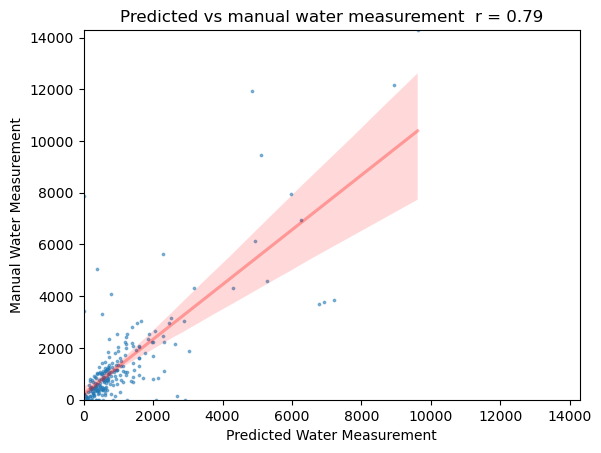

In [51]:
# Create scatter plot with regression line
plot = sns.regplot(
    x=pred_water_area,
    y=manual_water_area,
    scatter_kws={"s": 3, "alpha": 0.5},
    line_kws={"color": "red", "alpha": 0.3},
)

# Calculate the correlation coefficient (r value)
r_value, p_value = scipy.stats.pearsonr(pred_water_area, manual_water_area)
plt.title(f"Predicted vs manual water measurement  r = {r_value:.2f}")
plt.xlabel("Predicted Water Measurement")
plt.ylabel("Manual Water Measurement")

max_limit = max(max(pred_water_area), max(manual_water_area))
plt.xlim(0, max_limit)
plt.ylim(0, max_limit)
plt.show()

In [52]:
mean_absolute_error(val_points["manual_water_area"], pred_water_area)

652.0430865100702

In [58]:
#  add pred_water_area to val_points and calculate error
val_points.drop(columns=["water_area"], inplace=True)
val_points["pred_water_area"] = pred_water_area
val_points["abs_error"] = abs(
    val_points["manual_water_area"] - val_points["pred_water_area"]
)
val_points["pct_abs_error"] = val_points["abs_error"] / val_points["manual_water_area"]

In [60]:
# export to csv
val_points.to_csv("validation_output.csv", index=False)